In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d

In [2]:
mu0 = np.array([1, 1])
mu1 = np.array([5, 5])
Sigma0 = np.array([[1, 0], [0, 1]])
Sigma1 = np.array([[1, 0], [0, 1]])

X0 = np.random.multivariate_normal(mu0, Sigma0, size=(10000))
X1 = np.random.multivariate_normal(mu1, Sigma1, size=(10000))

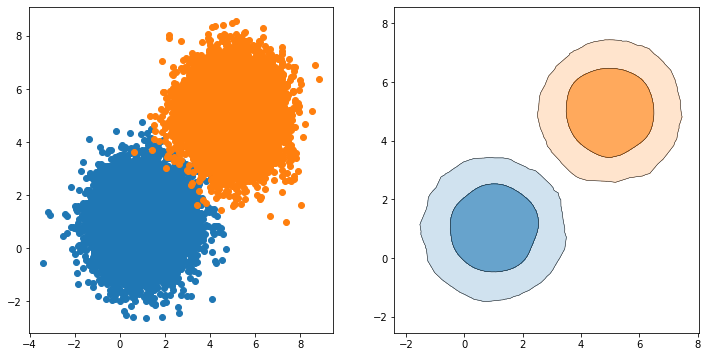

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(X0[:, 0], X0[:, 1])
axs[0].scatter(X1[:, 0], X1[:, 1])

kde_contour_plot_2d(axs[1], X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs[1], X1[:, 0], X1[:, 1])

plt.show()

## 1D Gaussian tension coordinate *t*
#### This is the analytical approach

t = \mu \Sigma^{-1} \theta

\mu = \mu_A - \mu_B

\Sigma = \Sigma_A + \Sigma_B

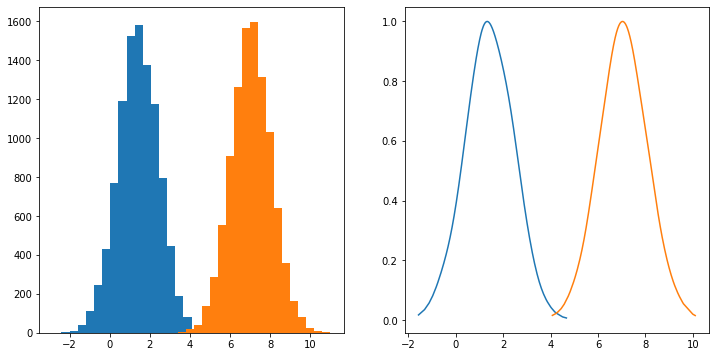

In [4]:
def dot_n(n, X):
    if n.shape[0] != X.shape[1]:
        raise ValueError("shape of n and X do not match")
    else:
        return np.matmul(np.transpose(n), np.transpose(X))

direc_n = np.matmul(np.transpose(mu0 - mu1), np.linalg.inv(Sigma0 + Sigma1))
direc_n = -direc_n / np.linalg.norm(direc_n)

X0_1d = dot_n(direc_n, X0)
X1_1d = dot_n(direc_n, X1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(X0_1d, bins=20)
axs[0].hist(X1_1d, bins=20)
kde_plot_1d(axs[1], X0_1d)
kde_plot_1d(axs[1], X1_1d)

## General tension coordinate t

Want to optimise the tension coordinate against a tension quantification method (either Bayes factor R or Suspiciousness statistic S)

### Bayes Factor R

We use the binning method as defined in the draft document written by Will and Liam

In [5]:
def get_limits(points):
    min_max = []
    for row in np.transpose(points):
        min_val = min(row)
        max_val = max(row)
        padding = (max_val - min_val) / 10
        min_max.append([min_val - padding, max_val + padding])
    
    return min_max

def bin_1d_kde(kde, limits, N=100):
    bin_width = (limits[1] - limits[0]) / N
    bins = [(limits[0] + i * bin_width, limits[0] + (i+1) * bin_width) for i in range(N)]
    bin_mids = [bin[0] + bin_width / 2 for bin in bins]
    weights = [kde.integrate_box(bin[0], bin[1]) for bin in bins]

    return bin_mids, weights    

def uniform_prior_samples(limits, size=1000):
    prior_samples = []
    for limit in limits:
        prior_samples.append(np.random.uniform(limit[0], limit[1], size=size))
    return np.transpose(np.array(prior_samples))

In [16]:
all_samples = np.concatenate((X0, X1), axis=0)
prior_limits = get_limits(all_samples)
X_prior = uniform_prior_samples(prior_limits, size=10000)

def marginalised_bayes_factor(n, XA, XB, X_prior):
    XA_1d = dot_n(n, XA)
    XB_1d = dot_n(n, XB)
    X_prior_1d = dot_n(n, X_prior)

    kdeA_1d = gaussian_kde(XA_1d)
    kdeB_1d = gaussian_kde(XB_1d)
    kde_prior_1d = gaussian_kde(X_prior_1d)

    kdeA_limits = get_limits(np.reshape(XA_1d, (-1, 1)))
    kdeB_limits = get_limits(np.reshape(XB_1d, (-1, 1)))
    kde_prior_limits = get_limits(np.reshape(X_prior_1d, (-1, 1)))

    binsA, weightsA = bin_1d_kde(kdeA_1d, kdeA_limits[0])
    binsB, weightsB = bin_1d_kde(kdeB_1d, kdeB_limits[0])
    bins_prior, weights_prior = bin_1d_kde(kde_prior_1d, kde_prior_limits[0])

    R = 0
    N_bins = 50 
    low_lim = kde_prior_limits[0][0]
    high_lim = kde_prior_limits[0][1]
    bin_width = (high_lim - low_lim) / N_bins
    large_bins = [(low_lim + i * bin_width, low_lim + (i + 1) * bin_width) for i in range(N_bins)]

    def weights_within_bin(idx, bins, weights, lower_lim, upper_lim):
        sum_A = 0
        for i in range(idx, len(bins)):
            if bins[i] > lower_lim and bins[i] < upper_lim:
                sum_A += weights[i]
                idx += 1
            else:
                break

        return idx, sum_A

    idxA = 0
    idxB = 0
    idx_prior = 0
    for large_bin in large_bins:
        idxA, sum_A = weights_within_bin(idxA, binsA, weightsA, large_bin[0], large_bin[1])
        idxB, sum_B = weights_within_bin(idxB, binsB, weightsB, large_bin[0], large_bin[1])
        idx_prior, sum_prior = weights_within_bin(idx_prior, bins_prior, weights_prior, large_bin[0], large_bin[1])
        
        if sum_prior != 0:
            R += (sum_A * sum_B) / sum_prior

    return R


def marginalised_bayes_factor_without_kde(n, XA, XB, X_prior):
    XA_1d = dot_n(n, XA)
    XB_1d = dot_n(n, XB)
    X_prior_1d = dot_n(n, X_prior)

    counts_A, bin_edges_A = np.histogram(XA_1d, bins=500)
    counts_B, bin_edges_B = np.histogram(XB_1d, bins=500)
    counts_prior, bin_edges_prior = np.histogram(X_prior_1d, bins=50)
    
    bin_width_A = bin_edges_A[1] - bin_edges_A[0]
    bin_width_B = bin_edges_B[1] - bin_edges_B[0]
    bin_width_prior = bin_edges_prior[1] - bin_edges_prior[0]
    bins_A = [b + (bin_width_A / 2) for b in bin_edges_A[:-1]]
    bins_B = [b + (bin_width_B / 2) for b in bin_edges_B[:-1]]
    # bins_prior = [b + bin_width_prior for b in bin_edges_prior[:-1]]
    weights_A = counts_A / len(XA_1d)
    weights_B = counts_B / len(XB_1d)
    weights_prior = counts_prior / len(X_prior_1d)
    
    R = 0
    def weights_within_bin(idx, bins, weights, lower_lim, upper_lim):
        sum_A = 0
        for i in range(idx, len(bins)):
            if bins[i] > lower_lim and bins[i] < upper_lim:
                sum_A += weights[i]
                idx += 1
            else:
                break

        return idx, sum_A

    idxA = 0
    idxB = 0
    idx_prior = 0
    for i in range(len(bin_edges_prior) - 1):
        low_lim = bin_edges_prior[i]
        up_lim = bin_edges_prior[i+1]
        idxA, sum_A = weights_within_bin(idxA, bins_A, weights_A, low_lim, up_lim)
        idxB, sum_B = weights_within_bin(idxB, bins_B, weights_B, low_lim, up_lim)
        # print(round(sum_A, 10), round(sum_B, 10), round(weights_prior[i], 10))
    
        if weights_prior[i] != 0:
            R += (sum_A * sum_B) / weights_prior[i]

    return R




In [17]:
marginalised_bayes_factor_without_kde(np.array(norm_n(np.pi / 4)), X0, X1, X_prior)

0 0 0.003
0 0 0.0026
0 0 0.0049
0 0 0.0071
0 0 0.0071
0 0 0.0084
0 0 0.0121
0.0001 0 0.0109
0.0001 0 0.0151
0.0005 0 0.013
0.0017 0 0.0159
0.0059 0 0.0181
0.0151 0 0.0195
0.0309 0 0.0213
0.0513 0 0.0232
0.0872 0 0.0275
0.1212 0 0.0245
0.1547 0 0.0269
0.1466 0 0.0286
0.1293 0 0.0325
0.1092 0 0.0336
0.0739 0 0.0316
0.0421 0.0001 0.0374
0.0183 0.0003 0.0383
0.0086 0.001 0.039
0.0019 0.0026 0.0368
0.0009 0.0086 0.0361
0.0004 0.0205 0.0364
0.0001 0.0393 0.0315
0 0.073 0.0329
0 0.1047 0.0351
0 0.1386 0.0281
0 0.1625 0.0277
0 0.1457 0.0259
0 0.117 0.0243
0 0.0846 0.0218
0 0.0512 0.0213
0 0.0289 0.0191
0 0.0131 0.0199
0 0.0058 0.018
0 0.0019 0.0157
0 0.0004 0.0142
0 0.0002 0.0113
0 0 0.0102
0 0 0.0077
0 0 0.0083
0 0 0.0062
0 0 0.0048
0 0 0.0029
0 0 0.0017


0.001175101894590508

In [8]:
thetas = np.linspace(0, 2 * np.pi, 100)
def norm_n(theta):
    return [np.cos(theta), np.sin(theta)]

R = np.array([marginalised_bayes_factor_without_kde(np.array(norm_n(theta)), X0, X1, X_prior) for theta in thetas])

2]
0 0 [0.0055 0.0131 0.0185 0.0204 0.0208 0.0225 0.0204 0.0212 0.0205 0.0203
 0.0214 0.0207 0.0199 0.0201 0.0192 0.0195 0.0225 0.0189 0.0241 0.0233
 0.0223 0.0211 0.0219 0.0212 0.0242 0.0215 0.0208 0.0212 0.023  0.022
 0.019  0.0208 0.022  0.019  0.0209 0.0217 0.0213 0.0215 0.0192 0.0206
 0.02   0.0223 0.0185 0.0228 0.0235 0.0193 0.0201 0.019  0.0123 0.0042]
0 0 [0.0055 0.0131 0.0185 0.0204 0.0208 0.0225 0.0204 0.0212 0.0205 0.0203
 0.0214 0.0207 0.0199 0.0201 0.0192 0.0195 0.0225 0.0189 0.0241 0.0233
 0.0223 0.0211 0.0219 0.0212 0.0242 0.0215 0.0208 0.0212 0.023  0.022
 0.019  0.0208 0.022  0.019  0.0209 0.0217 0.0213 0.0215 0.0192 0.0206
 0.02   0.0223 0.0185 0.0228 0.0235 0.0193 0.0201 0.019  0.0123 0.0042]
0 0 [0.0055 0.0131 0.0185 0.0204 0.0208 0.0225 0.0204 0.0212 0.0205 0.0203
 0.0214 0.0207 0.0199 0.0201 0.0192 0.0195 0.0225 0.0189 0.0241 0.0233
 0.0223 0.0211 0.0219 0.0212 0.0242 0.0215 0.0208 0.0212 0.023  0.022
 0.019  0.0208 0.022  0.019  0.0209 0.0217 0.0213 0.0215 0.0192

Text(0.5, 1.0, 'Marginalised pdf at max R, theta = 5.522 rad')

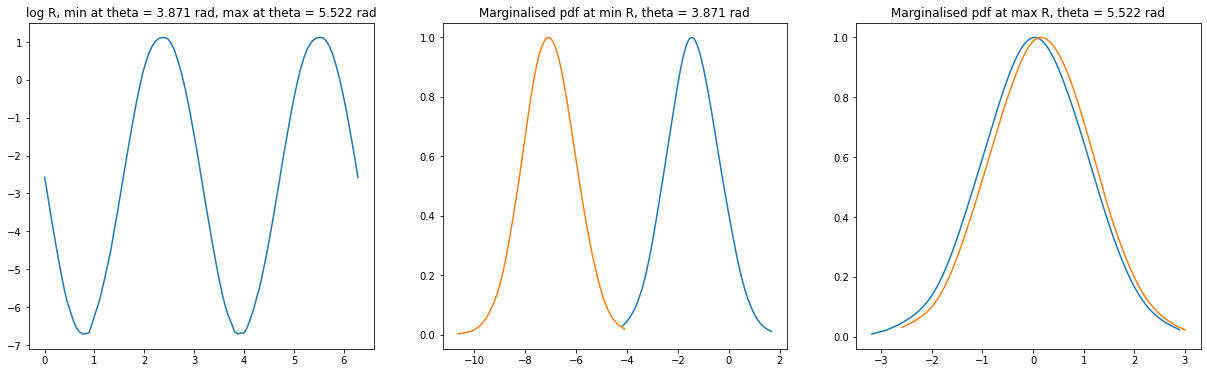

In [14]:
min_theta = thetas[np.argmin(R)]
max_theta = thetas[np.argmax(R)]

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
axs[0].plot(thetas, np.log(R))
axs[0].set_title(f"log R, min at theta = {round(min_theta, 3)} rad, max at theta = {round(max_theta, 3)} rad")

min_n = np.array([np.cos(min_theta), np.sin(min_theta)])
X0_min = dot_n(min_n, X0)
X1_min = dot_n(min_n, X1)
kde_plot_1d(axs[1], X0_min)
kde_plot_1d(axs[1], X1_min)
axs[1].set_title(f"Marginalised pdf at min R, theta = {round(min_theta, 3)} rad")

max_n = np.array([np.cos(max_theta), np.sin(max_theta)])
X0_max = dot_n(max_n, X0)
X1_max = dot_n(max_n, X1)
kde_plot_1d(axs[2], X0_max)
kde_plot_1d(axs[2], X1_max)
axs[2].set_title(f"Marginalised pdf at max R, theta = {round(max_theta, 3)} rad")



### Suspiciousness Statistic S

We use the expression given in the latest draft of the ACT/SPT paper, which involves the average of log likelihoods

In [49]:
def likelihood_function(X, mean=np.array([6/np.sqrt(2)]), cov_mat=np.array([2])):
    if X.shape[1] != mean.shape[0] or mean.shape[0] != cov_mat.shape[0]:
        raise ValueError("dimensions do not match up.")
    else:
        likelihoods = multivariate_normal.pdf(X, mean, cov_mat)
    
    return likelihoods

def marginalised_suspiciousness(n, XA, XB):
    XA_1d = dot_n(n, XA)
    XB_1d = dot_n(n, XB)
    XAB_1d = np.concatenate((XA_1d, XB_1d), axis=0)

    kdeA_1d = gaussian_kde(XA_1d)
    kdeB_1d = gaussian_kde(XB_1d)
    kdeAB_1d = gaussian_kde(XAB_1d)

    kdeA_limits = get_limits(np.reshape(XA_1d, (-1, 1)))
    kdeB_limits = get_limits(np.reshape(XB_1d, (-1, 1)))
    kdeAB_limits = get_limits(np.reshape(XAB_1d, (-1, 1)))

    binsA, weightsA = bin_1d_kde(kdeA_1d, kdeA_limits[0])
    binsB, weightsB = bin_1d_kde(kdeB_1d, kdeB_limits[0])
    binsAB, weightsAB = bin_1d_kde(kdeAB_1d, kdeAB_limits[0])

    # let likelihood function have mean of 6/sqrt(2) and covariance of 2
    avg_llhd_A = sum([np.log(likelihood_function(np.array([[binsA[i]]]))) * weightsA[i] for i in range(len(weightsA))])
    avg_llhd_B = sum([np.log(likelihood_function(np.array([[binsB[i]]]))) * weightsB[i] for i in range(len(weightsB))])
    avg_llhd_AB = sum([np.log(likelihood_function(np.array([[binsAB[i]]]))) * weightsAB[i] for i in range(len(weightsAB))])

    log_S = avg_llhd_AB - avg_llhd_A - avg_llhd_B
    return log_S

In [51]:
thetas = np.linspace(0, 2 * np.pi, 100)
def norm_n(theta):
    return [np.cos(theta), np.sin(theta)]

log_S = np.array([marginalised_bayes_factor(np.array(norm_n(theta)), X0, X1, X_prior) for theta in thetas])

Text(0.5, 1.0, 'Marginalised pdf at max log S, theta = 2.348 rad')

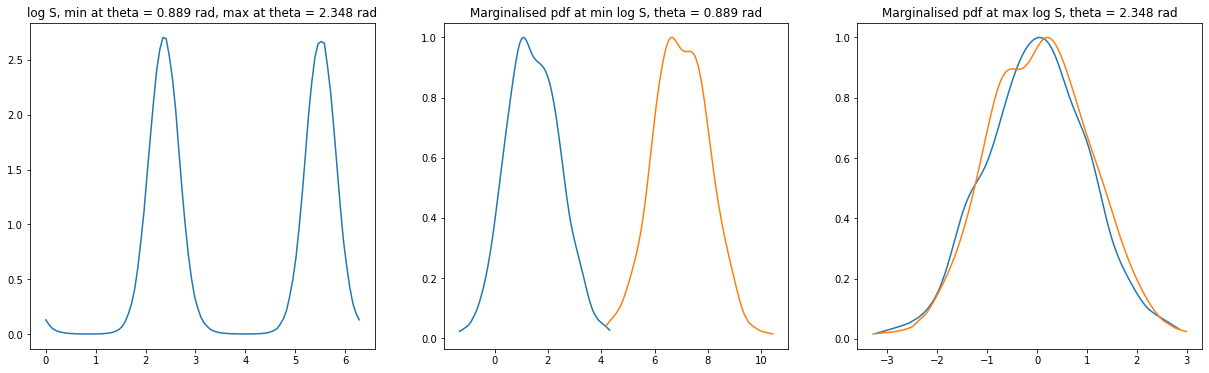

In [52]:
min_theta = thetas[np.argmin(log_S)]
max_theta = thetas[np.argmax(log_S)]

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
axs[0].plot(thetas, log_S)
axs[0].set_title(f"log S, min at theta = {round(min_theta, 3)} rad, max at theta = {round(max_theta, 3)} rad")

min_n = np.array([np.cos(min_theta), np.sin(min_theta)])
X0_min = dot_n(min_n, X0)
X1_min = dot_n(min_n, X1)
kde_plot_1d(axs[1], X0_min)
kde_plot_1d(axs[1], X1_min)
axs[1].set_title(f"Marginalised pdf at min log S, theta = {round(min_theta, 3)} rad")

max_n = np.array([np.cos(max_theta), np.sin(max_theta)])
X0_max = dot_n(max_n, X0)
X1_max = dot_n(max_n, X1)
kde_plot_1d(axs[2], X0_max)
kde_plot_1d(axs[2], X1_max)
axs[2].set_title(f"Marginalised pdf at max log S, theta = {round(max_theta, 3)} rad")

Let's plot T(theta)